# Explainable AI in Spanish
> (SPANISH) IA explicable con ejemplo de detección de fraude en el sector financiero

- toc: true
- badges: true
- comments: true
- categories: ["Structured Data"]
- image: images/googlecloud.png


# Introducción

Aviso: la versión original en inglés de este notebook está en [este Codelab](https://codelabs.developers.google.com/codelabs/fraud-detection-ai-explanations/index.html?index=..%2F..index#0)

# Instalación

In [1]:
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import json
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

## Carga de datos

Es un dataset sintético de Kaggle, con trasacciones fraudulentas.
Son 6.3 millones de registros, y 8000 son fraudulentas (sólo el 0.1!)

In [2]:
!gsutil cp gs://financial_fraud_detection/fraud_data_kaggle.csv .

Copying gs://financial_fraud_detection/fraud_data_kaggle.csv...
| [1 files][470.7 MiB/470.7 MiB]                                                
Operation completed over 1 objects/470.7 MiB.                                    


In [3]:
data = pd.read_csv('fraud_data_kaggle.csv')
data.head()
data.size

69988820

In [4]:
data['isFraud'].value_counts()


0    6354407
1       8213
Name: isFraud, dtype: int64

## Corregir datos desbalanceados
Usamos DOWNSAMPLING: consiste en usar todos los fraudulentos (8000) y solo 0.005 (31000) de los no-fraudulentos (clase minoritaria) 

In [5]:
fraud = data[data['isFraud'] == 1]
not_fraud = data[data['isFraud'] == 0]

In [6]:
# Take a random sample of non fraud rows
not_fraud_sample = not_fraud.sample(random_state=2, frac=.005)

# Put it back together and shuffle
df = pd.concat([not_fraud_sample,fraud])
df = shuffle(df, random_state=2)

# Remove a few columns (isFraud is the label column we'll use, not isFlaggedFraud)
df = df.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'])

# Preview the updated dataset
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
5777870,400,PAYMENT,65839.41,0.00,0.00,0.0,0.0,0
6362412,726,TRANSFER,561446.32,561446.32,0.00,0.0,0.0,1
5927827,404,PAYMENT,3828.08,10455.17,6627.09,0.0,0.0,0
5987904,410,TRANSFER,557950.06,557950.06,0.00,0.0,0.0,1
5706694,398,PAYMENT,1376.57,368349.14,366972.57,0.0,0.0,0


In [7]:
df['isFraud'].value_counts()

0    31772
1     8213
Name: isFraud, dtype: int64

## Dividir entre set de entrenamiento y prueba (test)

In [8]:
train_test_split = int(len(df) * .8)

train_set = df[:train_test_split]
test_set = df[train_test_split:]

train_labels = train_set.pop('isFraud')
test_labels = test_set.pop('isFraud')

Definir features 

In [9]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['type']
NUMERIC_COLUMNS = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

In [10]:
def one_hot_cat_column(feature_name, vocab):
    return tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocab))

feature_columns = []

for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = train_set[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                           dtype=tf.float32))

## Funciones

In [11]:
NUM_EXAMPLES = len(train_labels)
def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    dataset = dataset.repeat(n_epochs)
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

# Define training and evaluation input functions
train_input_fn = make_input_fn(train_set, train_labels)
eval_input_fn = make_input_fn(test_set, test_labels, shuffle=False, n_epochs=1)

## Entrenar modelo Boosted Tree

In [12]:
n_batches = 1
model = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp8ko2kwtc', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fcb4fb77810>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
The old _FeatureColumn APIs a

In [13]:
model.train(train_input_fn, max_steps=100)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Type is unsupported, or the ty

In [14]:
result = model.evaluate(eval_input_fn)
print(pd.Series(result))

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-06-22T08:11:13Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp8ko2kwtc/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-06-22-08:11:15
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.9949981, accuracy_baseline = 0.8006753, auc = 0.99874365, auc_precision_recall = 0.99814403, average_loss = 0.024392342, global_step = 100, label/mean = 0.19932474, loss = 0.024392342, precision = 0.97903824, prediction/mean = 0.2005636, recall = 0.9962359
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Saving 'checkpoint

In [15]:
pred_dicts = list(model.predict(eval_input_fn))
probabilities = pd.Series([pred['logistic'][0] for pred in pred_dicts])

for i,val in enumerate(probabilities[:30]):
  print('Predicted: ', round(val), 'Actual: ', test_labels.iloc[i])
  print()

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp8ko2kwtc/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Predicted:  0 Actual:  0

Predicted:  1 Actual:  1

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  1 Actual:  1

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  1 Actual:  1

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predi

## Confusion matrix

In [16]:
y_pred = []

for i in probabilities.values:
  y_pred.append(int(round(i)))

In [17]:
cm = confusion_matrix(test_labels.values, y_pred)
print(cm)

[[6369   34]
 [   6 1588]]


In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 3)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

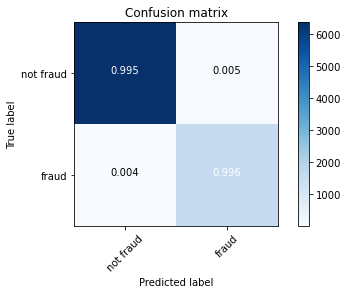

In [19]:
classes = ['not fraud', 'fraud']
plot_confusion_matrix(cm, classes, normalize=True)

## Preparando el despliegue del modelo en AI Platform (con Explainability)

In [20]:
GCP_PROJECT = 'windy-site-254307'
MODEL_BUCKET = 'gs://fraud-detection-explainable-ai'
!gsutil mb $MODEL_BUCKET


Creating gs://fraud-detection-explainable-ai/...
ServiceException: 409 Bucket fraud-detection-explainable-ai already exists.


### Exportamos el modelo en TensorFlow 1.x

In [21]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
def json_serving_input_fn():
  inputs = {}
  for feat in feature_columns:
      if feat.name == "type_indicator":
            inputs['type'] = tf.placeholder(shape=[None], name=feat.name, dtype=tf.string)
      else:
          inputs[feat.name] = tf.placeholder(shape=[None], name=feat.name, dtype=feat.dtype)
  return tf.estimator.export.ServingInputReceiver(inputs, inputs)

export_path = model.export_saved_model(
    MODEL_BUCKET + '/explanations',
    serving_input_receiver_fn=json_serving_input_fn
).decode('utf-8')

tf.enable_v2_behavior()

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Signatures EXCLUDED from export because they cannot be be served via TensorFlow Serving APIs:
INFO:tensorflow:'serving_default' : Classification input must be a single string Tensor; got {'type': <tf.Tensor 'type_indicator:0' shape=(?,) dtype=string>, 'step': <tf.Tensor 'step:0' shape=(?,) dtype=float32>, 'amount': <tf.Tensor 'amount:0' shape=(?,) dtype=float32>, 'oldbalanceOrg': <tf.T

In [23]:
!saved_model_cli show --dir $export_path --all



MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['predict']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['amount'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: amount:0
    inputs['newbalanceDest'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: newbalanceDest:0
    inputs['newbalanceOrig'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: newbalanceOrig:0
    inputs['oldbalanceDest'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: oldbalanceDest:0
    inputs['oldbalanceOrg'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: oldbalanceOrg:0
    inputs['step'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: step:0
    inputs['type'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: type_indicator:0
  The given SavedModel SignatureDef contains the following

In [24]:
not_fraud.median()


step                 239.00
amount             74684.72
oldbalanceOrg      14069.00
newbalanceOrig         0.00
oldbalanceDest    133311.80
newbalanceDest    214881.70
isFraud                0.00
isFlaggedFraud         0.00
dtype: float64

In [25]:
not_fraud['type'].value_counts()


CASH_OUT    2233384
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     528812
DEBIT         41432
Name: type, dtype: int64

In [26]:
!gsutil cp explanation_metadata.json $export_path




Copying file://explanation_metadata.json [Content-Type=application/json]...
/ [1 files][  718.0 B/  718.0 B]                                                
Operation completed over 1 objects/718.0 B.                                      


In [ ]:
!gsutil cp gs://fraud-detection-explainable-ai/explanations/1592218671/explanation_metadata.json .
!gsutil cp explanation_metadata.json $export_path

## Despliegue e AI Platform explanations

In [27]:
MODEL = 'fraud_detection_4'
VERSION = 'v3'

In [28]:
!gcloud ai-platform models create $MODEL


Learn more about regional endpoints and see a list of available regions: https://cloud.google.com/ai-platform/prediction/docs/regional-endpoints
ERROR: (gcloud.ai-platform.models.create) Resource in project [windy-site-254307] is the subject of a conflict: Field: model.name Error: A model with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A model with the same name already exists.
    field: model.name


In [29]:
!gcloud beta ai-platform versions create v3 \
--model $MODEL \
--origin $export_path \
--runtime-version 1.15 \
--framework TENSORFLOW \
--python-version 3.7 \
--machine-type n1-standard-4 \
--explanation-method 'sampled-shapley' \
--num-paths 10

Explanations reflect patterns in your model, but don't necessarily reveal fundamental relationships about your data population. See https://cloud.google.com/ml-engine/docs/ai-explanations/limitations for more information.
ERROR: (gcloud.beta.ai-platform.versions.create) ALREADY_EXISTS: Field: version.name Error: A version with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A version with the same name already exists.
    field: version.name


In [30]:
!gcloud ai-platform versions describe $VERSION --model $MODEL


createTime: '2020-06-15T14:20:08Z'
deploymentUri: gs://fraud-detection-explainable-ai/explanations/1592230714
etag: yuDcVfyBSAQ=
explanationConfig:
  sampledShapleyAttribution:
    numPaths: 10
framework: TENSORFLOW
isDefault: true
lastUseTime: '2020-06-18T07:20:48Z'
machineType: n1-standard-4
name: projects/windy-site-254307/models/fraud_detection_4/versions/v3
pythonVersion: '3.7'
runtimeVersion: '1.15'
state: READY


## Predicción con explicabilidad

### Paso 1: preparamos datos (data.txt)

In [31]:
fraud_indices = []

for i,val in enumerate(test_labels):
    if val == 1:
        fraud_indices.append(i)

In [32]:
num_test_examples = 5
import numpy as np 

def convert(o):
    if isinstance(o, np.generic): return o.item()  
    raise TypeError

for i in range(num_test_examples):
    test_json = {}
    ex = test_set.iloc[fraud_indices[i]]
    keys = ex.keys().tolist()
    vals = ex.values.tolist()
    for idx in range(len(keys)):
        test_json[keys[idx]] = vals[idx]

    print(test_json)
    with open('data.txt', 'a') as outfile:
        json.dump(test_json, outfile, default=convert)
        outfile.write('\n')

{'step': 476, 'type': 'TRANSFER', 'amount': 1048.63, 'oldbalanceOrg': 1048.63, 'newbalanceOrig': 0.0, 'oldbalanceDest': 0.0, 'newbalanceDest': 0.0}
{'step': 390, 'type': 'TRANSFER', 'amount': 638693.49, 'oldbalanceOrg': 638693.49, 'newbalanceOrig': 0.0, 'oldbalanceDest': 0.0, 'newbalanceDest': 0.0}
{'step': 355, 'type': 'CASH_OUT', 'amount': 5338162.8, 'oldbalanceOrg': 5338162.8, 'newbalanceOrig': 0.0, 'oldbalanceDest': 181895.58, 'newbalanceDest': 5520058.37}
{'step': 356, 'type': 'TRANSFER', 'amount': 357226.8, 'oldbalanceOrg': 357226.8, 'newbalanceOrig': 0.0, 'oldbalanceDest': 0.0, 'newbalanceDest': 0.0}
{'step': 345, 'type': 'TRANSFER', 'amount': 128936.95, 'oldbalanceOrg': 128936.95, 'newbalanceOrig': 0.0, 'oldbalanceDest': 0.0, 'newbalanceDest': 0.0}


In [33]:
!cat data.txt


{"step": 476, "type": "TRANSFER", "amount": 1048.63, "oldbalanceOrg": 1048.63, "newbalanceOrig": 0.0, "oldbalanceDest": 0.0, "newbalanceDest": 0.0}
{"step": 390, "type": "TRANSFER", "amount": 638693.49, "oldbalanceOrg": 638693.49, "newbalanceOrig": 0.0, "oldbalanceDest": 0.0, "newbalanceDest": 0.0}
{"step": 355, "type": "CASH_OUT", "amount": 5338162.8, "oldbalanceOrg": 5338162.8, "newbalanceOrig": 0.0, "oldbalanceDest": 181895.58, "newbalanceDest": 5520058.37}
{"step": 356, "type": "TRANSFER", "amount": 357226.8, "oldbalanceOrg": 357226.8, "newbalanceOrig": 0.0, "oldbalanceDest": 0.0, "newbalanceDest": 0.0}
{"step": 345, "type": "TRANSFER", "amount": 128936.95, "oldbalanceOrg": 128936.95, "newbalanceOrig": 0.0, "oldbalanceDest": 0.0, "newbalanceDest": 0.0}
{"step": 476, "type": "TRANSFER", "amount": 1048.63, "oldbalanceOrg": 1048.63, "newbalanceOrig": 0.0, "oldbalanceDest": 0.0, "newbalanceDest": 0.0}
{"step": 390, "type": "TRANSFER", "amount": 638693.49, "oldbalanceOrg": 638693.49, "n

### Step 2: enviamos data.txt al modelo con gcloud beta ai-platform explain

In [34]:
explanations = !gcloud beta ai-platform explain --model $MODEL --version $VERSION --json-instances='data.txt' --verbosity error

'{   "explanations": [     {       "attributions_by_label": [         {           "approx_error": 0.07222782395555333,           "attributions": {             "amount": 0.6966777056455612,             "newbalanceDest": 0.1639272928237915,             "newbalanceOrig": 0.0,             "oldbalanceDest": 0.16475289762020112,             "oldbalanceOrg": -0.15600235760211945,             "step": 0.1192602276802063,             "type": -0.027230754494667053           },           "baseline_score": 0.013069868087768555,           "example_score": 0.9744548797607422,           "label_index": 0,           "output_name": "prob"         }       ]     },     {       "attributions_by_label": [         {           "approx_error": 0.004716743469869621,           "attributions": {             "amount": -0.0019459187984466552,             "newbalanceDest": 0.007967007160186768,             "newbalanceOrig": 0.0,             "oldbalanceDest": 0.008247834444046021,             "oldbalanceOrg": 0.978411

In [35]:
explain_dict = json.loads(explanations.s)

In [36]:
### Step 3: análisis de datos (notad el baseline)

In [37]:
print('Model baseline for fraud cases: ', explain_dict['explanations'][0]['attributions_by_label'][0]['baseline_score'], '\n')


Model baseline for fraud cases:  0.013069868087768555 



Model prediction: 0.9744548797607422


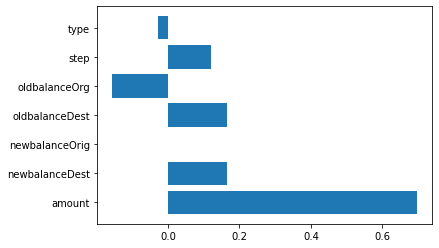

Model prediction: 0.9985994100570679


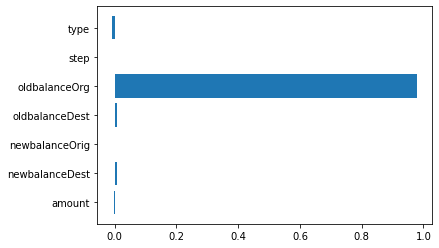

Model prediction: 0.9933480024337769


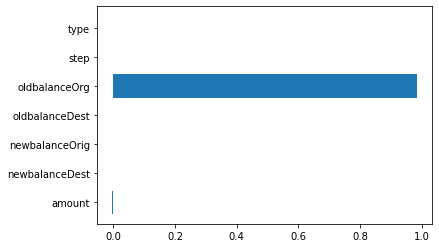

Model prediction: 0.9977060556411743


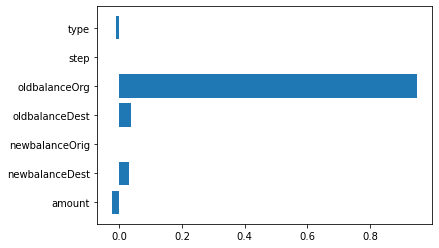

Model prediction: 0.9938302040100098


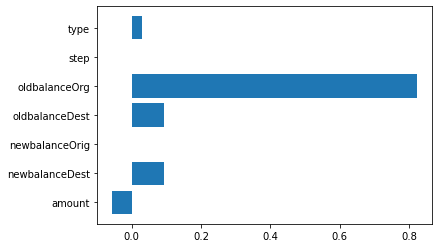

Model prediction: 0.9744548797607422


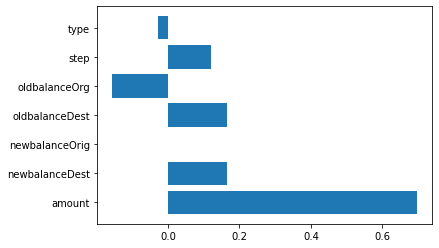

Model prediction: 0.9985994100570679


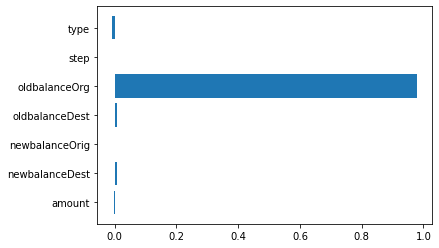

Model prediction: 0.9933480024337769


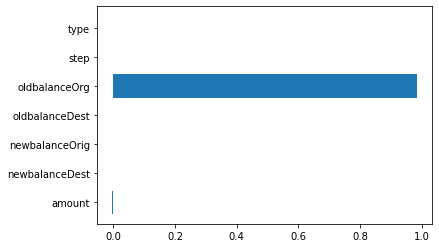

Model prediction: 0.9977060556411743


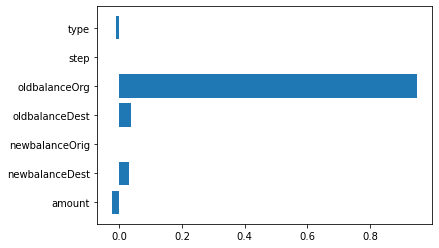

Model prediction: 0.9938302040100098


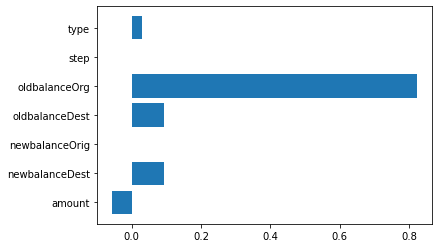

Model prediction: 0.9744548797607422


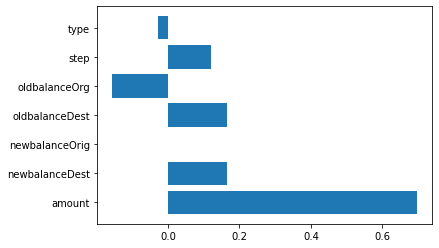

Model prediction: 0.9985994100570679


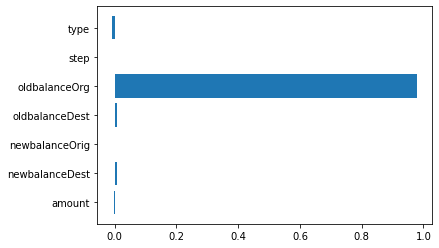

Model prediction: 0.9933480024337769


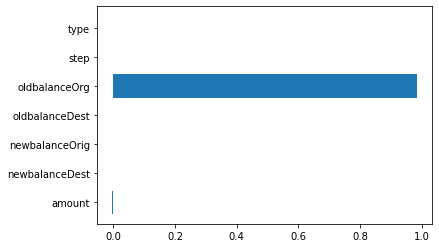

Model prediction: 0.9977060556411743


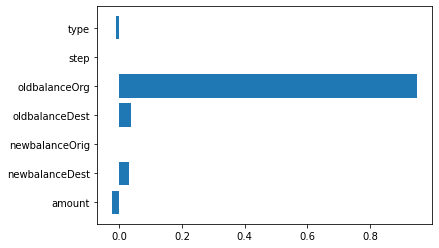

Model prediction: 0.9938302040100098


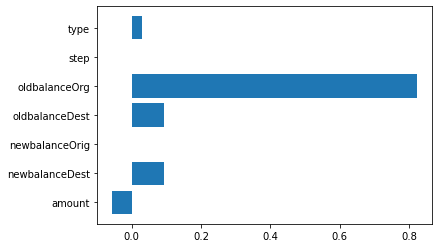

Model prediction: 0.9744548797607422


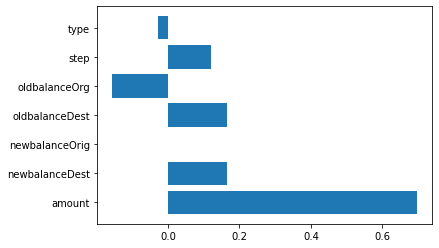

Model prediction: 0.9985994100570679


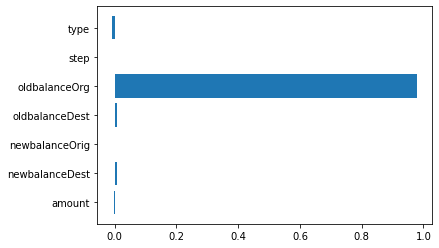

Model prediction: 0.9933480024337769


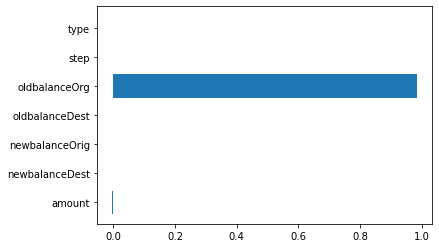

Model prediction: 0.9977060556411743


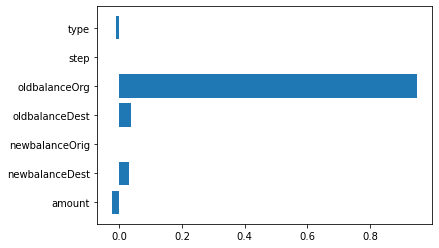

Model prediction: 0.9938302040100098


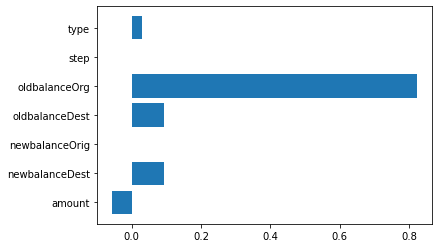

Model prediction: 0.9744548797607422


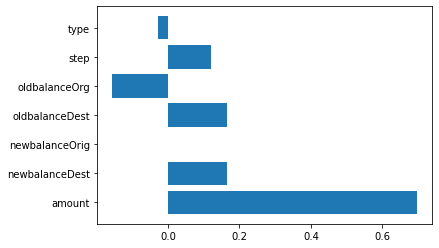

Model prediction: 0.9985994100570679


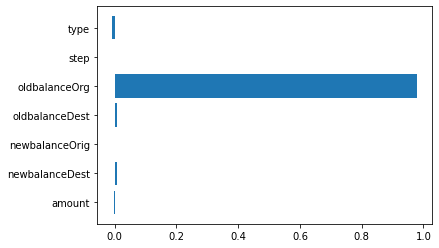

Model prediction: 0.9933480024337769


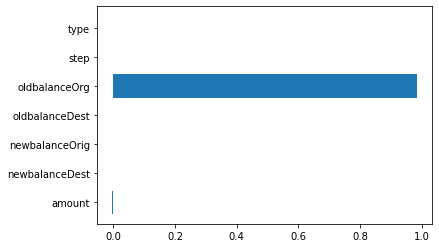

Model prediction: 0.9977060556411743


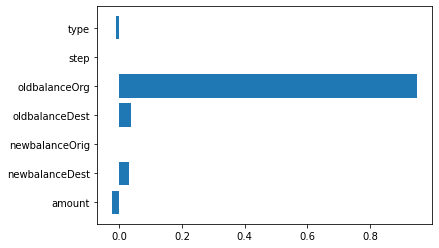

Model prediction: 0.9938302040100098


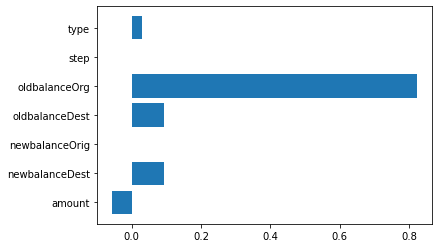

Model prediction: 0.9744548797607422


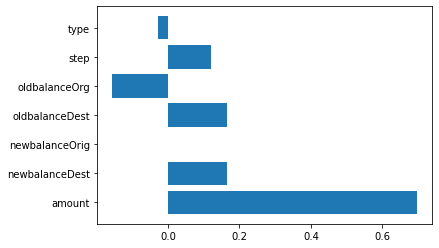

Model prediction: 0.9985994100570679


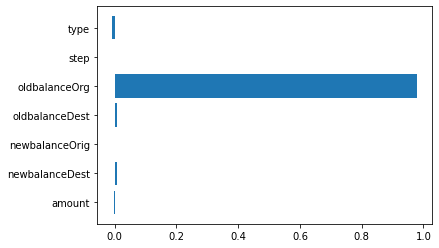

Model prediction: 0.9933480024337769


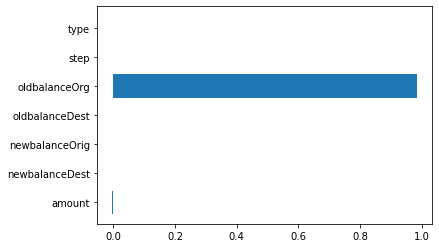

Model prediction: 0.9977060556411743


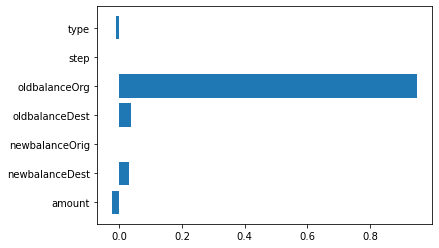

Model prediction: 0.9938302040100098


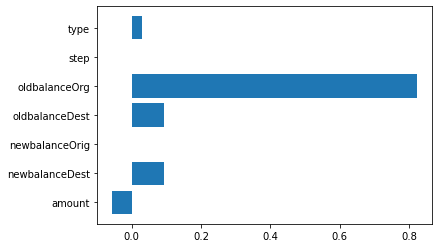

Model prediction: 0.9744548797607422


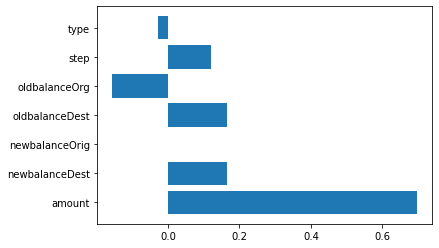

Model prediction: 0.9985994100570679


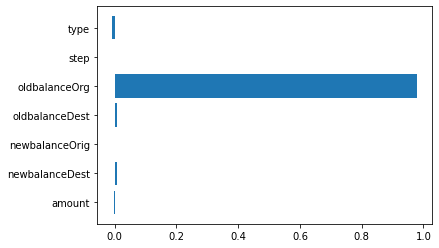

Model prediction: 0.9933480024337769


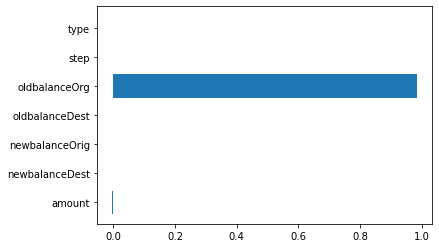

Model prediction: 0.9977060556411743


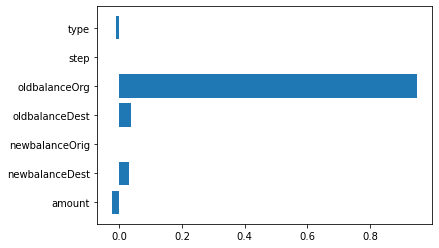

Model prediction: 0.9938302040100098


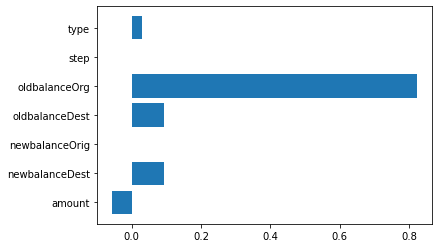

Model prediction: 0.9744548797607422


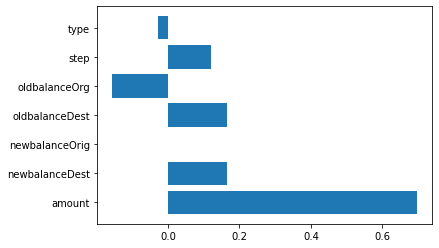

Model prediction: 0.9985994100570679


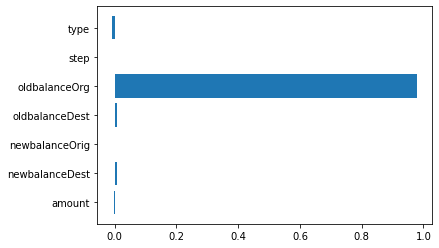

Model prediction: 0.9933480024337769


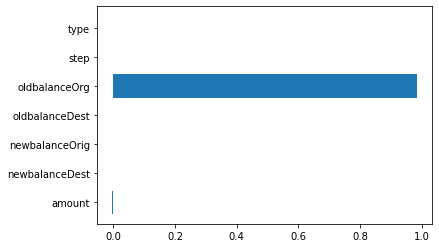

Model prediction: 0.9977060556411743


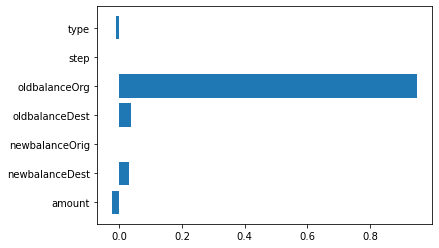

Model prediction: 0.9938302040100098


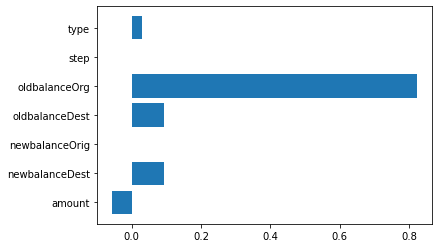

Model prediction: 0.9744548797607422


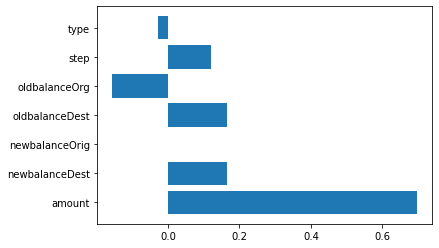

Model prediction: 0.9985994100570679


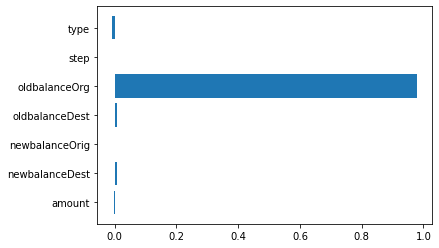

Model prediction: 0.9933480024337769


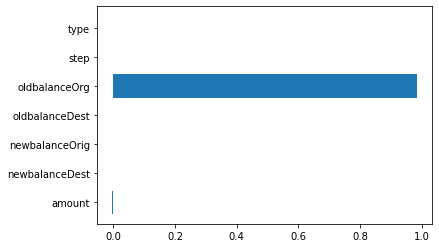

Model prediction: 0.9977060556411743


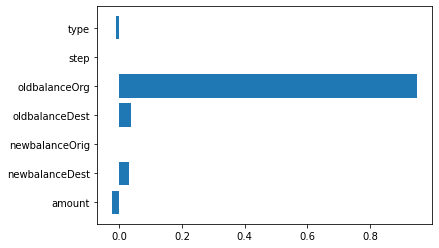

Model prediction: 0.9938302040100098


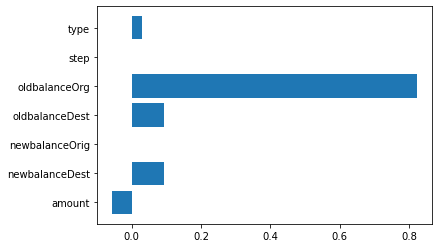

In [38]:
for i in explain_dict['explanations']:
    prediction_score = i['attributions_by_label'][0]['example_score']
    attributions = i['attributions_by_label'][0]['attributions']
    print('Model prediction:', prediction_score)
    fig, ax = plt.subplots()
    ax.barh(list(attributions.keys()), list(attributions.values()), align='center')
    plt.show()